# Data validation

In [1]:
%matplotlib inline

# Import from helpers
import sys
import os
sys.path.append(os.path.dirname(os.getcwd()) + '/helpers')
from data_wrapper import DataWrapper

from shapely.geometry import LineString
import contextily as cx
import pandas as pd
import geopandas as gpd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

import numpy as np
import statsmodels.formula.api as smf
from scipy import stats

from pathlib import Path

In [2]:
matplotlib.rcParams.update({
    "pgf.texsystem": "pdflatex",
    'font.family': 'serif',
    'text.usetex': True,
    'pgf.rcfonts': False,
    # Use 10pt font in plots, a little smaller than 12pt font in document
    "axes.labelsize": 10,
    "font.size": 10,
    # Make the legend/label fonts a little smaller
    "legend.fontsize": 8,
    "xtick.labelsize": 8,
    "ytick.labelsize": 8
})
textwidth_in = 5.5129 # taken from LaTeX document
textwidth_pt = 398.3386 # taken from LaTeX document
with open('../paths/figures-path.txt') as f:
    figures_path = Path(f.read())
with open('../paths/tables-path.txt') as f:
    tables_path = Path(f.read())

In [3]:
# from https://jwalton.info/Embed-Publication-Matplotlib-Latex/
def set_size(width, fraction=1, subplots=(1, 1)):
    """Set figure dimensions to avoid scaling in LaTeX.

    Parameters
    ----------
    width: float or string
            Document width in points, or string of predined document type
    fraction: float, optional
            Fraction of the width which you wish the figure to occupy
    subplots: array-like, optional
            The number of rows and columns of subplots.
    Returns
    -------
    fig_dim: tuple
            Dimensions of figure in inches
    """
    if width == 'thesis':
        width_pt = 398.3386
    elif width == 'beamer':
        width_pt = 307.28987
    else:
        width_pt = width

    # Width of figure (in pts)
    fig_width_pt = width_pt * fraction
    # Convert from pt to inches
    inches_per_pt = 1 / 72.27

    # Golden ratio to set aesthetic figure height
    # https://disq.us/p/2940ij3
    golden_ratio = (5**.5 - 1) / 2

    # Figure width in inches
    fig_width_in = fig_width_pt * inches_per_pt
    # Figure height in inches
    fig_height_in = fig_width_in * golden_ratio * (subplots[0] / subplots[1])

    return (fig_width_in, fig_height_in)

In [4]:
with open('../paths/data-path.txt') as f:
    data_path = f.read()
version = '2022-08-02_20-02-15'
dw = DataWrapper(version, data_path)

In [5]:
dw.load_version(
    single_tracks_filename='Vienna_2017-2022',
    #single_tracks_filename='Vienna_2017-2022_10pc',
    download_missing_tracks=False
)

Positions of counters are taken from [nast consulting](https://www.nast.at/leistungsspektrum/verkehrsmanagement-und-verkehrssteuerung/verkehrsdaten/)

In [6]:
# Coordinates extracted from OpenStreetMap, uses EPSG 4326 (WGS84)
counter_series = gpd.GeoSeries(
    [
        LineString([(16.3724, 48.1943), (16.3745, 48.1948)]),
        LineString([(16.3691, 48.25548), (16.37043, 48.25562)]),
        LineString([(16.46927, 48.21911), (16.46918, 48.21852)]),
        LineString([(16.39961, 48.22342), (16.40020, 48.22307)]),
        LineString([(16.31221, 48.15520), (16.31256, 48.15483)]),
        LineString([(16.33859, 48.19856), (16.33918, 48.19868)]),
        LineString([(16.36691, 48.20295), (16.36741, 48.20353)]),
        LineString([(16.36675, 48.20250), (16.36691, 48.20295)]),
        LineString([(16.36675, 48.20250), (16.36741, 48.20353)]),
        LineString([(16.31507, 48.18804), (16.31486, 48.18713)]),
        LineString([(16.35450, 48.19541), (16.35504, 48.19526)]),
        LineString([(16.36687, 48.20085), (16.36740, 48.20076)]),
        LineString([(16.39030, 48.21859), (16.39074, 48.21850)]),
        LineString([(16.34467, 48.20903), (16.34471, 48.20865)]),
    ]
)
counter_names = [
    'Argentinierstraße',
    'Donaukanal',
    'Langobardenstraße',
    'Lassallestraße',
    'Liesingbach',
    'Neubaugürtel ',
    'Opernring Innen',
    'Opernring Außen',
    'Opernring', # = Opernring Innen + Opernring Außen
    'Wienzeile',
    'Margaritensteg ',
    'Operngasse',
    'Praterstern',
    'Pfeilgasse'
]
counters = gpd.GeoDataFrame(counter_names, geometry=counter_series, crs=4326).set_index(0)

In [7]:
district_boundaries = gpd.read_file('../geo_data/BEZIRKSGRENZEOGD.json')
city_boundaries = district_boundaries.dissolve().explode()

/var/folders/hy/vpm71bsj40g8d9qhfg95kmtc0000gn/T/ipykernel_40319/1193612173.py:2: FutureWarning: Currently, index_parts defaults to True, but in the future, it will default to False to be consistent with Pandas. Use `index_parts=True` to keep the current behavior and True/False to silence the warning.
  city_boundaries = district_boundaries.dissolve().explode()


/var/folders/hy/vpm71bsj40g8d9qhfg95kmtc0000gn/T/ipykernel_40319/3488259687.py:4: UserWarning: Geometry is in a geographic CRS. Results from 'buffer' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  counters.geometry.buffer(0.003).plot(ax=ax, color='red', edgecolor='none')


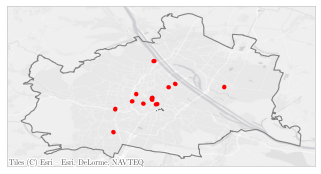

In [8]:
#matplotlib.use('pgf')
#matplotlib.use('pdf')
fig, ax = plt.subplots(figsize=set_size(textwidth_pt, 1))
counters.geometry.buffer(0.003).plot(ax=ax, color='red', edgecolor='none')
city_boundaries.plot(ax=ax, facecolor='none', edgecolor='grey', linewidth=1)
cx.add_basemap(ax, crs=counters.crs.to_string(), source=cx.providers.Esri.WorldGrayCanvas)
#cx.add_basemap(ax, crs=counters.crs.to_string(), source=cx.providers.CartoDB.PositronNoLabels)
ax.grid(False)
ax.tick_params(
    axis='both', which='both',
    bottom=False, labelbottom=False,
    top=False, labeltop=False,
    left=False, labelleft=False,
    right=False, labelright=False
)
# Uncomment to save figure
#plt.savefig(figures_path / 'counters.pgf', bbox_inches='tight', dpi=160)
#plt.savefig(figures_path / 'counters.pdf', format='pdf', bbox_inches='tight', dpi=160)

/Users/samuel.hoenle/opt/anaconda3/envs/DissertationProject/lib/python3.9/site-packages/contextily/tile.py:581: UserWarning: The inferred zoom level of 23 is not valid for the current tile provider (valid zooms: 0 - 19).
  warnings.warn(msg)


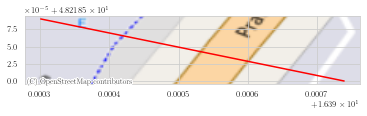

In [9]:
ax = counters.loc[counters.index.str.contains('Praterstern')].plot(color='red')
cx.add_basemap(ax, crs=counters.crs.to_string(), source=cx.providers.OpenStreetMap.Mapnik)

/Users/samuel.hoenle/opt/anaconda3/envs/DissertationProject/lib/python3.9/site-packages/contextily/tile.py:581: UserWarning: The inferred zoom level of 20 is not valid for the current tile provider (valid zooms: 0 - 19).
  warnings.warn(msg)


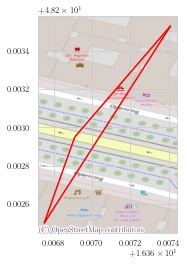

In [10]:
ax = counters.loc[counters.index.str.contains('Opernring')].plot(color='red')
cx.add_basemap(ax, crs=counters.crs.to_string(), source=cx.providers.OpenStreetMap.Mapnik)

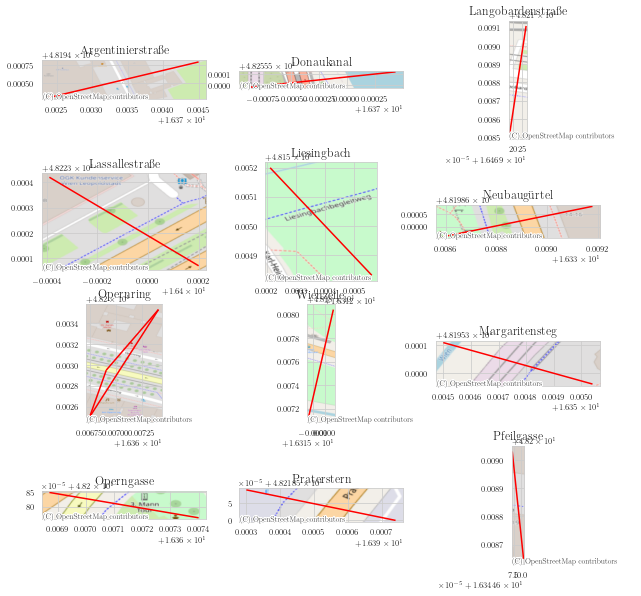

In [11]:
fig, axs = plt.subplots(ncols=3, nrows=4, figsize=(10, 10))
counter_names_for_plot = list(counters.index)
counter_names_for_plot.remove('Opernring Innen')
counter_names_for_plot.remove('Opernring Außen')
for row in range(4):
    for col in range(3):
        name = counter_names_for_plot[row*3+col]
        counters.loc[counters.index.str.contains(name)].plot(color='red', ax=axs[row, col], aspect=1.0)
        cx.add_basemap(axs[row, col], crs=counters.crs.to_string(), source=cx.providers.OpenStreetMap.Mapnik, zoom=19)
        axs[row, col].title.set_text(name)

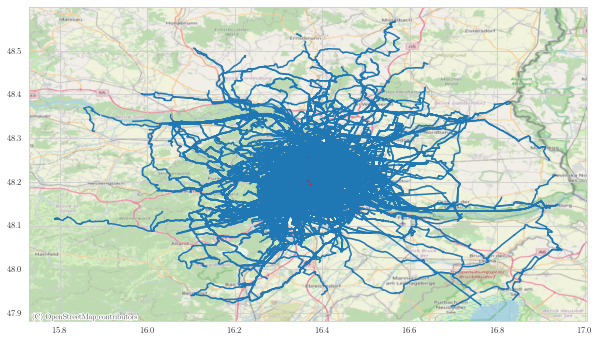

In [12]:
fig, ax = plt.subplots(figsize = (10,10))
dw.tracks.plot(ax=ax)
counters.to_crs(dw.tracks.crs).plot(ax=ax, color='red')
cx.add_basemap(ax, crs=dw.tracks.crs.to_string(), source=cx.providers.OpenStreetMap.Mapnik)

In [13]:
def count_daily_intersects(tracks_to_test, counters_to_test, start_date, end_date):
    counts = pd.DataFrame(columns=counters_to_test.index,index=pd.date_range(start_date, end_date, freq='D'))
    for counter_name, row in counters_to_test.iterrows():
        intersecting = tracks_to_test[tracks_to_test.intersects(row.geometry)]
        for day in counts.index:
            day_tracks = intersecting[intersecting['start_time'].apply(lambda t: t.date()) == day.date()]
            counts.loc[day, counter_name] = day_tracks.shape[0]
    return counts

All counters in city data set became fully operational on 1 November 2017. Last day of city counter data is 31 December 2021.

In [14]:
# TODO check for file presence
#track_intersect_counts = count_daily_intersects(dw.tracks, counters, '2017-11-01', '2021-12-31')
#track_intersect_counts.to_csv(dw.dh.data_folder_path / dw.version / 'track_counts_11-2017_12-2021.csv')
track_intersect_counts = dw.dh.load_tracks_counter_data(dw.version, 'track_counts_11-2017_12-2021')
track_intersect_counts.head()

,Argentinierstraße,Donaukanal,Langobardenstraße,Lassallestraße,Liesingbach,Neubaugürtel,Opernring Innen,Opernring Außen,Opernring,Wienzeile,Margaritensteg,Operngasse,Praterstern,Pfeilgasse
2017-11-01,0,2,0,0,0,2,0,0,0,0,0,0,0,0
2017-11-02,0,0,0,0,0,1,3,0,3,1,0,3,1,1
2017-11-03,0,0,0,0,2,0,1,1,2,1,0,1,0,1
2017-11-04,0,0,0,0,0,0,0,1,1,2,0,0,1,0
2017-11-05,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [15]:
counter_data = dw.dh.load_city_counter_data()
counter_data['Datum'] = pd.to_datetime(counter_data['Datum'], format='%Y%m%d')
counter_data.set_index('Datum', inplace=True)

In [16]:
def prepare_regression_data(counters_df, track_count_df):
    track_count_df['date'] = track_count_df.index
    transformed_tracks_count = track_count_df.melt(id_vars=['date'], var_name='location', value_name='count_tracks')
    transformed_tracks_count['count_tracks'] = pd.to_numeric(transformed_tracks_count['count_tracks'])

    counters_df['date'] = counters_df.index
    transformed_counter_count = counters_df.melt(id_vars=['date'], var_name='location', value_name='count_counters')

    return pd.merge(transformed_tracks_count, transformed_counter_count, on=['date', 'location'])

In [17]:
regression_data_daily = prepare_regression_data(counter_data, track_intersect_counts)
regression_data_daily.head()

,date,location,count_tracks,count_counters
0,2017-11-01,Argentinierstraße,0,693.0
1,2017-11-02,Argentinierstraße,0,1841.0
2,2017-11-03,Argentinierstraße,0,1907.0
3,2017-11-04,Argentinierstraße,0,945.0
4,2017-11-05,Argentinierstraße,0,902.0


In [18]:
results_daily = smf.ols('count_counters ~ count_tracks', data=regression_data_daily).fit()
summary_daily = results_daily.summary(title='Validation regression: Daily counts', slim=True, yname='Daily counts', xname=['Intercept','Track counts'], alpha=0.05)
print(summary_daily)
# Uncomment to save table
#with open(tables_path / 'validation-daily.tex', 'w') as f:
#    latex = summary_daily.as_latex()
#    latex = latex.split('\n')[:-2] # remove note about standard errors
#    latex = '\n'.join(latex)
#    f.write(latex)

                     Validation regression: Daily counts                      
Dep. Variable:           Daily counts   R-squared:                       0.306
Model:                            OLS   Adj. R-squared:                  0.306
No. Observations:               21308   F-statistic:                     9396.
Covariance Type:            nonrobust   Prob (F-statistic):               0.00
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept     1302.0138     12.233    106.433      0.000    1278.036    1325.992
Track counts   549.6045      5.670     96.933      0.000     538.491     560.718

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.


In [19]:
stats.pearsonr(regression_data_daily.count_counters, regression_data_daily.count_tracks)

(0.5532088471474452, 0.0)

<AxesSubplot:xlabel='count_tracks', ylabel='count_counters'>

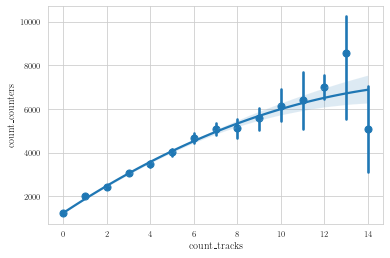

In [20]:
sns.regplot(
    x='count_tracks',
    y='count_counters',
    data=regression_data_daily,
    #x_jitter=.5,
    x_estimator=np.mean,
    #robust=True,
    order=2
)

## Weekly aggregation

In [21]:
# sums by week, date = last day of summed week (Sunday)
regression_data_weekly = prepare_regression_data(
    counter_data.resample('W').sum(),
    track_intersect_counts.resample('W').sum()
)
regression_data_weekly.head()

,date,location,count_tracks,count_counters
0,2017-11-05,Argentinierstraße,0,9293.0
1,2017-11-12,Argentinierstraße,0,11506.0
2,2017-11-19,Argentinierstraße,9,10870.0
3,2017-11-26,Argentinierstraße,8,9982.0
4,2017-12-03,Argentinierstraße,14,8384.0


In [22]:
results_weekly = smf.ols('count_counters ~ count_tracks', data=regression_data_weekly).fit()
summary_weekly = results_weekly.summary(title='Validation regression: Weekly counts', slim=True, yname='Weekly counts', xname=['Intercept','Track counts'], alpha=0.05)
print(summary_weekly)
# Uncomment to save table
#with open(tables_path / 'validation-weekly.tex', 'w') as f:
#    latex = summary_weekly.as_latex()
#    latex = latex.split('\n')[:-2] # remove note about standard errors
#    latex = '\n'.join(latex)
#    f.write(latex)

                     Validation regression: Weekly counts                     
Dep. Variable:          Weekly counts   R-squared:                       0.487
Model:                            OLS   Adj. R-squared:                  0.486
No. Observations:                3052   F-statistic:                     2891.
Covariance Type:            nonrobust   Prob (F-statistic):               0.00
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept     5750.5999    208.801     27.541      0.000    5341.195    6160.005
Track counts   930.0916     17.299     53.766      0.000     896.173     964.010

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.


In [23]:
stats.pearsonr(regression_data_weekly.count_counters, regression_data_weekly.count_tracks)

(0.6975702249201876, 0.0)

<AxesSubplot:xlabel='count_tracks', ylabel='count_counters'>

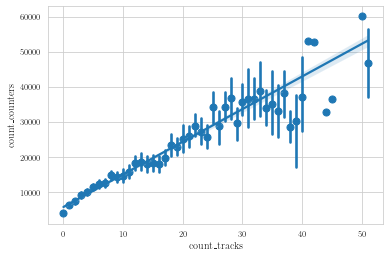

In [24]:
sns.regplot(
    x='count_tracks',
    y='count_counters',
    data=regression_data_weekly,
    #x_jitter=.5,
    x_estimator=np.mean
)

## Monthly aggregation

In [25]:
# sums by month, date = last day of summed month
regression_data_monthly = prepare_regression_data(
    counter_data.resample('M').sum(),
    track_intersect_counts.resample('M').sum())
regression_data_monthly.head()

,date,location,count_tracks,count_counters
0,2017-11-30,Argentinierstraße,28,44594.0
1,2017-12-31,Argentinierstraße,30,28588.0
2,2018-01-31,Argentinierstraße,35,32902.0
3,2018-02-28,Argentinierstraße,42,24556.0
4,2018-03-31,Argentinierstraße,46,36158.0


In [26]:
results_monthly = smf.ols('count_counters ~ count_tracks', data=regression_data_monthly).fit()
summary_monthly = results_monthly.summary(title='Validation regression: Monthly counts', slim=True, yname='Monthly counts', xname=['Intercept','Track counts'], alpha=0.05)
print(summary_monthly)
# Uncomment to save table
#with open(tables_path / 'validation-monthly.tex', 'w') as f:
#    latex = summary_monthly.as_latex()
#    latex = latex.split('\n')[:-2] # remove note about standard errors
#    latex = '\n'.join(latex)
#    f.write(latex)

                    Validation regression: Monthly counts                     
Dep. Variable:         Monthly counts   R-squared:                       0.554
Model:                            OLS   Adj. R-squared:                  0.553
No. Observations:                 700   F-statistic:                     865.7
Covariance Type:            nonrobust   Prob (F-statistic):          2.28e-124
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept      1.96e+04   1829.775     10.714      0.000     1.6e+04    2.32e+04
Track counts  1071.3154     36.412     29.422      0.000     999.825    1142.805

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.


In [27]:
stats.pearsonr(regression_data_monthly.count_counters,
               regression_data_monthly.count_tracks)

(0.7440504660823355, 2.2789190747136277e-124)

<AxesSubplot:xlabel='count_tracks', ylabel='count_counters'>

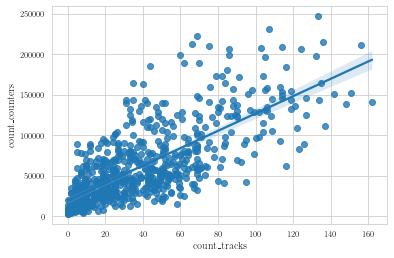

In [28]:
sns.regplot(
    x='count_tracks',
    y='count_counters',
    data=regression_data_monthly,
    #x_estimator=np.mean
)

## Per counter

Correlation might vary per counter. Check if correlation is higher for high-volume counting stations.

In [29]:
r_weekly_per_counter = pd.DataFrame(columns=["Pearson's R", 'p-value'], index=counter_names)
for cname in counter_names:
    crd = prepare_regression_data(
        counter_data[[cname]].resample('W').sum(),
        track_intersect_counts[[cname]].resample('W').sum()
    )
    pr = stats.pearsonr(crd.count_counters, crd.count_tracks)
    r_weekly_per_counter.loc[cname]["Pearson's R"] = pr[0]
    r_weekly_per_counter.loc[cname]['p-value'] = pr[1]

In [30]:
r_weekly_per_counter

,Pearson's R,p-value
Argentinierstraße,0.506141,0.0
Donaukanal,0.463225,0.0
Langobardenstraße,0.395875,0.0
Lassallestraße,0.723621,0.0
Liesingbach,0.526276,0.0
Neubaugürtel,0.568107,0.0
Opernring Innen,0.638541,0.0
Opernring Außen,0.574728,0.0
Opernring,0.683405,0.0
Wienzeile,0.555468,0.0


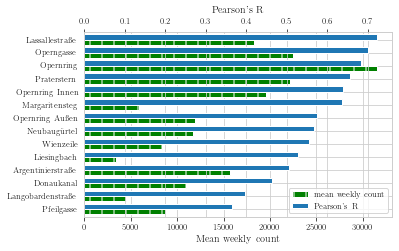

In [31]:
#matplotlib.use('pgf')
#matplotlib.use('pdf')

ind = np.array(list(range(len(r_weekly_per_counter))))
width = 0.4

fig, ax = plt.subplots(figsize=set_size(textwidth_pt, 1))
#ax.set_title('Correlation coefficients and mean weekly counts per counting station')
ax.barh(ind + width/2, regression_data_weekly.groupby('location').mean()['count_counters'].reindex(r_weekly_per_counter["Pearson's R"].sort_values(ascending=True).index), width, color='green', label="mean weekly count", hatch='|')
ax.set_xlabel('Mean weekly count')
ax2 = ax.twiny()
ax2.barh(ind + width*1.5, r_weekly_per_counter["Pearson\'s R"].sort_values(ascending=True), width, label="Pearson's R")
ax2.set_xlabel("Pearson's R")
ax.set(yticks=ind + width, yticklabels=np.array(r_weekly_per_counter["Pearson\'s R"].sort_values(ascending=True).index), ylim=[2*width - 1, len(ind)])
fig.legend(loc='lower right', bbox_to_anchor=(1,0), bbox_transform=ax.transAxes)

# Uncomment to save figure
#plt.savefig(figures_path / 'R-per-station.pgf', bbox_inches='tight')
#plt.savefig(figures_path / 'R-per-station.pdf', format='pdf', bbox_inches='tight')

In [32]:
stats.pearsonr(
    r_weekly_per_counter["Pearson\'s R"],
    regression_data_weekly.groupby('location').mean()['count_counters'].reindex(r_weekly_per_counter["Pearson's R"].index)
)

(0.6720531002534287, 0.008470490486781427)

## Per month

Check if there is a change in correlation over time.

In [33]:
r_weekly_per_month = pd.DataFrame(columns=["Pearson's R", 'p-value'], index=pd.date_range('2017-11', '2021-12', freq='M'))
for t in r_weekly_per_month.index:
    rd = prepare_regression_data(
        counter_data[(counter_data.date.dt.year == t.year) & (counter_data.date.dt.month == t.month)].resample('W').sum(),
        track_intersect_counts[(track_intersect_counts.date.dt.year == t.year) & (track_intersect_counts.date.dt.month == t.month)].resample('W').sum()
    )
    pr = stats.pearsonr(rd.count_counters, rd.count_tracks)
    r_weekly_per_month.loc[t]["Pearson's R"] = pr[0]
    r_weekly_per_month.loc[t]['p-value'] = pr[1]

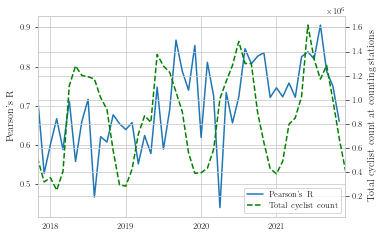

In [34]:
#matplotlib.use('pgf')

fig, ax = plt.subplots()
fig.set_size_inches(w=textwidth_in, h=textwidth_in*.67)
#ax.set_title('Correlation and total cyclist count over time')
r_weekly_per_month["Pearson\'s R"].plot(
    ax=ax,
    #ylim=(0, 1)
)
ax.set_ylabel("Pearson's R")
ax2 = ax.twinx()
counter_data.resample('M').sum().sum(axis=1).plot(
    style='g--',
    ax=ax2,
    #color='green',
    xlim=(pd.to_datetime('2017-11-01'), None),
    #ylim=(0, 2000000),
    label='Total cyclist count'
)
ax2.set_ylabel("Total cyclist count at counting stations")
fig.legend(loc='lower right', bbox_to_anchor=(1,0), bbox_transform=ax.transAxes)

# Uncomment to save figure
#plt.savefig(figures_path / 'R-per-month.pgf', bbox_inches='tight')